# Comparing the constant pressure Bessel Solution with my integrations of Newcomb's Euler-Lagrange equation

In this notebook I see if my integrations of Newcomb's Euler-Lagrange equation can match the analytical solution for $\xi$ in a constant pressure region given at the end of Newcomb's 1960 paper "Stability of Hydromagnetic Pinches".

The solution is given in equation (72) and is valid for a tubular pinch in a current free region from $a$ to $r_{0i}$.
The current free region is assumed to have a constant axial field $B_{z} = B_{zi}$ and a azimuthal field $B_{\theta} = \frac{B_{\theta i} r_{0i}}{r}$. The pressure is constant since there is no current. 
Eqution (72) is reproduced below:

$$\xi =  \frac{c k r}{k r B_{zi}+\frac{m r_{0i}}{r}B_{\theta i}} [I_{m}'(kr)K_{m}'(|ka|) - K_{m}'(|kr|)I_{m}'(ka)]$$

This equation assumes the nboundary condition $\xi(r=a) = 0$. There is a free parameter c. To match this equation to my integrations I will first assume $c=1$, then I will divide set $c$ to the ratio of the maximum values of the integration and the analytical solution.
I also need an initial condition for the derivative of $xi$ to integrate the Euler-Lagrange equation. The derivative is what sets the maximum of the integrated function. I will set it to 1.

# Setup

First I import the packages and modules I will need.

## Import Plotting

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')
%matplotlib inline

## Import Scipy packages

In [2]:
import numpy as np
from scipy.special import ivp, iv, kvp, kv

## Import Newcomb integration packages

In [21]:
import sys
sys.path.append('..')

import newcomb_simple as new
import newcomb_f as f
import newcomb_g as g
import singularity_frobenius as frob
import newcomb_init as init
import equil_solver as es

reload(es)
reload(new)
reload(f)
reload(g)
reload(frob)
reload(init)

<module 'newcomb_init' from '../newcomb_init.pyc'>

In [4]:
import sympy as sp

In [5]:
sp.init_printing()

In [6]:
c, k, r, b_zi, m, r_0i, b_thetai, x, a = sp.symbols('c k r b_zi m r_0i b_thetai x a')

In [7]:
def besseli_der(m, arg):
   return sp.diff(sp.besseli(m, x), x).subs(x, arg)

In [8]:
def besselk_der(m, arg):
   return sp.diff(sp.besselk(m, x), x).subs(x, arg)

In [9]:
besseli_der(m, k*a)

In [10]:
c*k*r/(k*r*b_zi + m*r_0i/r*b_thetai)*(besseli_der(m, k*r)*besselk_der(m, np.abs(k*a)) - besselk_der(m, np.abs(k*r))*besseli_der(m, k*a))

ValueError: 
\frac{c k r}{b_{thetai} m r_{0i} / r + b_{zi} k r} \left(- \left(I_{m - 1}\left(a k\right) / 2 + I_{m + 1}\left(a k\right) / 2\right) \left(- K_{m - 1}\left(\left\lvert{k r}\right\rvert\right) / 2 - K_{m + 1}\left(\left\lvert{k r}\right\rvert\right) / 2\right) + \left(I_{m - 1}\left(k r\right) / 2 + I_{m + 1}\left(k r\right) / 2\right) \left(- K_{m - 1}\left(\left\lvert{a k}\right\rvert\right) / 2 - K_{m + 1}\left(\left\lvert{a k}\right\rvert\right) / 2\right)\right)
                                                                                                                                                                  ^
Expected a delimiter (at char 162), (line:1, col:163)

      ⎛  ⎛besseli(m - 1, a⋅k)   besseli(m + 1, a⋅k)⎞ ⎛  besselk(m - 1, │k⋅r│) 
c⋅k⋅r⋅⎜- ⎜─────────────────── + ───────────────────⎟⋅⎜- ───────────────────── 
      ⎝  ⎝         2                     2         ⎠ ⎝            2           
──────────────────────────────────────────────────────────────────────────────
                                                                              
                                                                              
                                                                              

  besselk(m + 1, │k⋅r│)⎞   ⎛besseli(m - 1, k⋅r)   besseli(m + 1, k⋅r)⎞ ⎛  bess
- ─────────────────────⎟ + ⎜─────────────────── + ───────────────────⎟⋅⎜- ────
            2          ⎠   ⎝         2                     2         ⎠ ⎝      
──────────────────────────────────────────────────────────────────────────────
         b_thetai⋅m⋅r₀ᵢ                                                       
         ────────────── + b_zi⋅k⋅r                 

In [16]:
derivative = sp.lambdify((r, c, k, b_zi, m, r_0i, b_thetai, a),
                                   sp.diff(c*k*r/(k*r*b_zi + m*r_0i/r*b_thetai)*
                                           (besseli_der(m, k*r)*besselk_der(m, np.abs(k*a)) -
                                            besselk_der(m, np.abs(k*r))*besseli_der(m, k*a)),r))

In [11]:
derivative(1, 1, 1, 1, 1, 1, 1, 1)

NameError: name 'derivative' is not defined

## Define analytical $\xi$ function

In [12]:
def xi_constant_pressure(r, k, m, r_0i, a, b_zi, b_thetai, c):
    r"""
    Return Newcomb's xi for constant pressure region equation (72)
    """
    return c*k*r/(k*r*b_zi + m*r_0i/r*b_thetai)*(ivp(m, k*r)*kvp(m, np.abs(k*a)) - kvp(m, np.abs(k*r))*ivp(m, k*a))

In [13]:
def xi_der_constant_pressure(derivative, r, k, m, r_0i, a, b_zi, b_thetai, c):
    xi_der_list = [float(derivative(r_position, c, k, b_zi, m, r_0i, b_thetai, a)) for r_position in r]
    return np.asarray(xi_der_list)

## Setup comparison function

In [14]:
def compare(derivative, k=1., m=1., max_step=None, method='lsoda'):
    r"""
    Returns a comparison plot of the analytical solution with my integration of Newcomb's Euler-Lagrange equation.
    """
    params = {'k': k, 'm': m, 'r_0i': 1., 'a': 0.1, 'b_zi': 0.1, 'b_thetai': 0.1, 'c': 1.}
    params['r'] = np.linspace(params['a'], params['r_0i'], 1000.)
    xi_analytic_params = dict(params)

    xi_analytic = xi_constant_pressure(**xi_analytic_params)
    #xi_der_analytic = xi_der_constant_pressure(derivative, **xi_analytic_params)
    
    equil = es.NewcombConstantPressure(a=params['a'], r_0i=params['r_0i'], k=params['k'], b_z0=params['b_zi'], 
                                       b_thetai=params['b_thetai'], points=250)
    splines = equil.get_tck_splines()
    params.update(splines)
    params.update({'beta_0': equil.beta_0, 'r_0': params['a'], 'a': params['r_0i'], 'xi_factor': 1.0, 'magnetic_potential_energy_ratio': 1.0, 'b': 'infinity'})
    
    results = new.stability(params, 1e-3, 1e-3, suppress_output=True,
                            method=method, rtol=None, max_step=max_step, nsteps=None,
                            skip_external_stability=True, diagnose=True)
    
    xi = results[0][-1]
    xi_der = results[1][-1]
    
    delta = xi_der/xi
    
    xi_der_analytic = np.diff(xi_analytic)[-1]
    delta_analytic = xi_der_analytic / xi_analytic[-1]
    
    return delta, delta_analytic
    
    #factor = xi_analytic[-1]/xi[0,-1]
    
    #fig, axes = plt.subplots(1, 2, figsize =(15,7))
    #axes[0].plot(params['r'], xi_constant_pressure(**xi_analytic_params))
    #axes[0].plot(r_array[0], xi[0]*factor, linestyle='--')
    #axes[0].legend(['Analytical', 'Integration'], loc='best')
    #axes[0].set_xlabel(r'$r$')
    #axes[0].set_ylabel(r'$\xi$')
    
    #axes[1].loglog(r_array[0, 1:], np.abs(residual)[-1])
    #axes[1].set_xlabel(r'$r$')
    #axes[1].set_ylabel(r'residual')
    
    #print np.abs(xi[0]*factor-xi_constant_pressure(**xi_analytic_params)).mean()
    
    #fig.tight_layout()

    #max_error = np.nanmax((xi[1:]-xi_constant_pressure(**xi_analytic_params)[1:]*factor)/xi_constant_pressure(**xi_analytic_params)[1:]*factor)
    #print 'max error ' + str(max_error)
    #return rs, xi, xi_constant_pressure(**xi_analytic_params)*factor
    
    

# Compare!

In [37]:
compare(derivative, k=1., m=1, method='lsoda', max_step=0.01)

In [54]:
compare(derivative, k=1., m=1, method='lsoda', max_step=0.01)

In [53]:
compare(derivative, k=1., m=0, method='dopri', max_step=0.01)

In [87]:
compare(k=1., m=-1., mu_0=consts.mu_0)

NameError: name 'consts' is not defined

singularities at []
max error 0.0


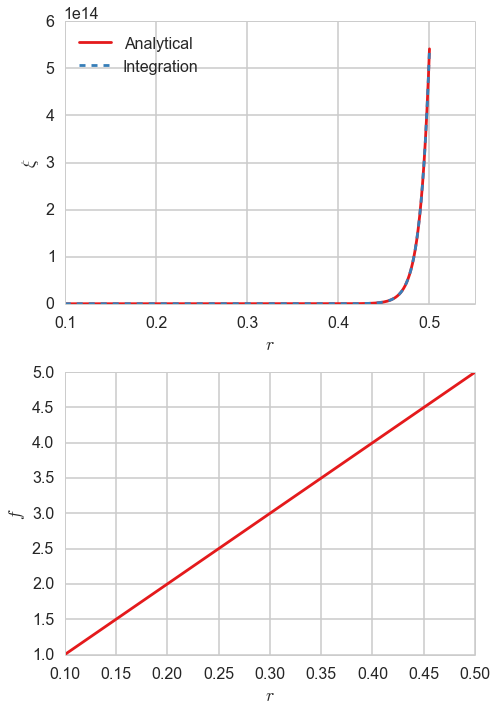

In [80]:
compare(k=100., m=0., mu_0=consts.mu_0)

singularities at []
max error 7.20558532157e-12


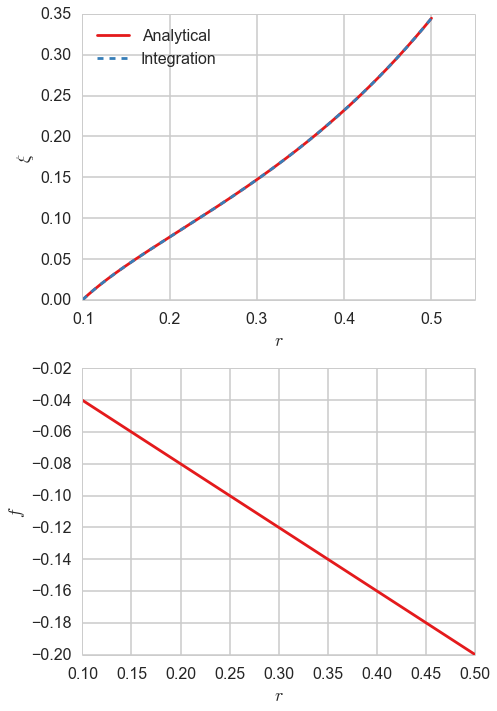

In [81]:
compare(k=-4., m=0., mu_0=consts.mu_0)

The integrations seem to match the analytical solutions well.

## What about cases with singularities? 

At the singularties the integration stops. While the analytial solution continues. I need to implement handeling of singularities. 

singularities at []
max error -0.0


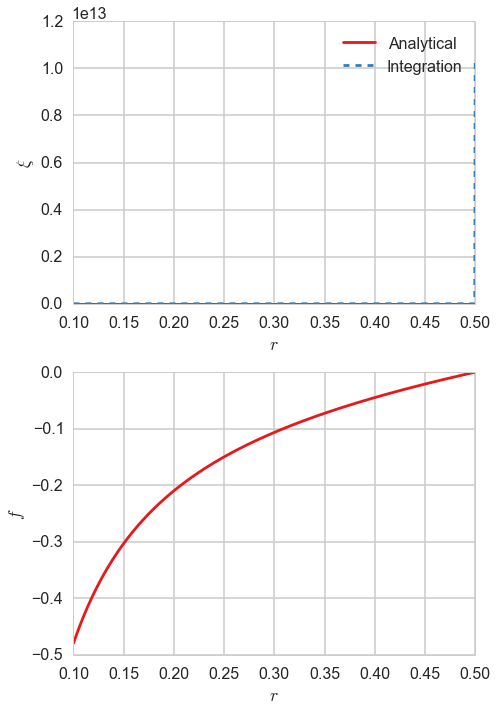

In [82]:
compare(k=2., m=-1., mu_0=consts.mu_0)

singularities at [ 0.40824829]


ValueError: operands could not be broadcast together with shapes (770,) (999,) 

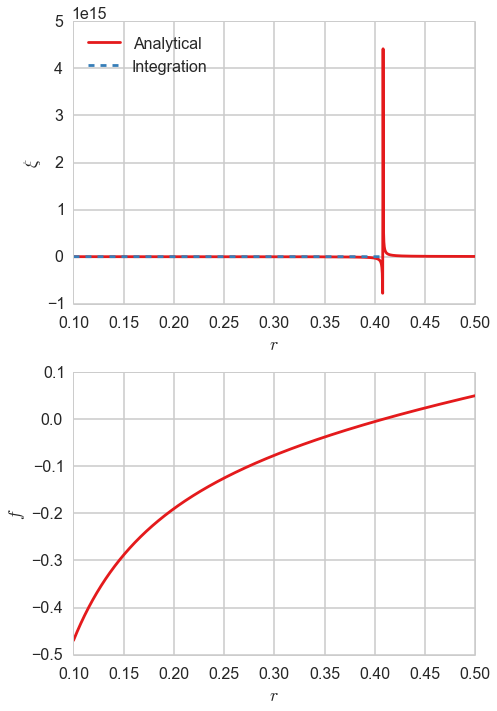

In [83]:
compare(k=3., m=-1., mu_0=consts.mu_0)

singularities at [ 0.35355339]


ValueError: operands could not be broadcast together with shapes (634,) (999,) 

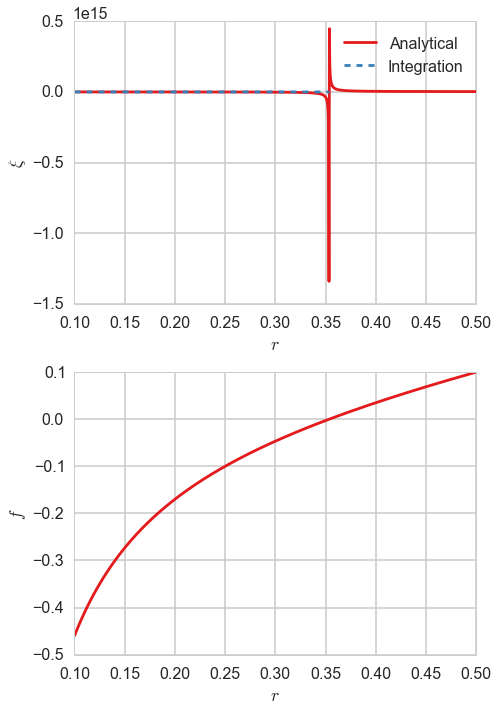

In [84]:
compare(k=4., m=-1., mu_0=consts.mu_0)

(-1000, 1000)

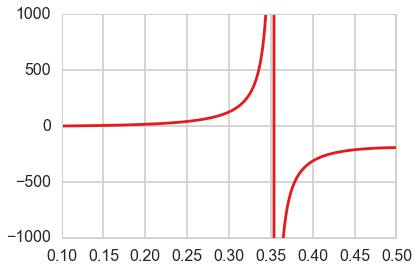

In [85]:
params = {'k': 4., 'm': -1., 'r_0i': 0.5, 'a': 0.1, 'b_zi': 0.1, 'b_thetai': 0.1, 'c': 1.}
params['r'] = np.linspace(params['a'], params['r_0i'], 1000.)
xi_analytic_params = dict(params)
plt.plot(params['r'], xi_constant_pressure(**xi_analytic_params))
plt.ylim((-1000,1000))

## Let's try to integrate this k=4, m=-1 case past the singularity with a frobenius method

First I'll do some code setup. I want to integrate 4 times:
1. From r=a to the singularity.
2. From the singularity to $r=a$, using the Forbenius solution.
3. From the singularity to $r=r_{0i}$, using the Frobenius solution.
4. From $r=r_{0i}$ to the singularity.

In [86]:
mu_0=consts.mu_0
sing_offset = 1E-3
params = {'k': 4., 'm': -1., 'r_0i': 0.5, 'a': 0.1, 'b_zi': 0.1, 'b_thetai': 0.1, 'c': 1.}
params['r'] = np.linspace(params['a'], params['r_0i'], 1000.)
xi_analytic_params = dict(params)
    
equil = es.NewcombConstantPressure()
splines = equil.get_splines()
params.update(splines)
params['mu_0'] = mu_0
dr = params['r'][1] - params['r'][0]
    
zeros = new.identify_singularties(params['a'], params['r_0i'], 100, params['k'], params['m'], params['b_z'], params['b_theta'])
print 'singularities at ' + str(zeros)

zero_pos = zeros[0]
b_z_sing = params['b_z'](zero_pos)
b_theta_sing = params['b_theta'](zero_pos)
b_z_prime_sing = params['b_z'].derivative()(zero_pos)
b_theta_prime_sing = params['b_theta'].derivative()(zero_pos)
p_prime_sing = params['p_prime'](zero_pos) 

alpha = frob.alpha_func(zero_pos, b_z_sing, b_z_prime_sing, b_theta_sing, b_theta_prime_sing)
beta = frob.beta_func(b_z_sing, b_theta_sing, p_prime_sing, mu_0)

print 'suydam stable: ' + str(frob.suydam_stable(alpha, beta))

nu_1, nu_2 = frob.nu_1_2(alpha, beta)
print nu_1, nu_2

r_init_left = zero_pos - sing_offset
r_init_right = zero_pos + sing_offset

xi_init_1_right = frob.sing_small_solution(zero_pos, -sing_offset, params['k'], params['m'], params['b_z'], params['b_theta'],
                         params['p_prime'], params['q'], f.newcomb_f_16, mu_0)
xi_init_2_left = frob.sing_small_solution(zero_pos, sing_offset, params['k'], params['m'], params['b_z'], params['b_theta'],
                         params['p_prime'], params['q'], f.newcomb_f_16, mu_0)


solution_1_left = new.newcomb_int(params['a'], dr, zero_pos - sing_offset, params, init.init_xi_given, f.newcomb_f_16, 
                                  g.newcomb_g_18, mu_0, reverse=False, xi_init=(0.0, 1.0))
solution_1_right = new.newcomb_int(zero_pos - sing_offset, -dr, params['a'], params, init.init_xi_given, f.newcomb_f_16, 
                                   g.newcomb_g_18, mu_0, reverse=True, xi_init=xi_init_1_right)
solution_2_left = new.newcomb_int(zero_pos + sing_offset, dr, params['r_0i'], params, init.init_xi_given, f.newcomb_f_16, 
                                   g.newcomb_g_18, mu_0, reverse=False, xi_init=xi_init_2_left)
solution_2_right = new.newcomb_int(params['r_0i'], -dr, zero_pos + sing_offset, params, init.init_xi_given, f.newcomb_f_16, 
                                   g.newcomb_g_18, mu_0, reverse=True, xi_init=(0.0, 1.0))

crossing_1_left, xi_1_left, xi_der_1_left, rs_1_left = solution_1_left

crossing_1_right, xi_1_right, xi_der_1_right, rs_1_right = solution_1_right

crossing_2_left, xi_2_left, xi_der_2_left, rs_2_left = solution_2_left

crossing_2_right, xi_2_right, xi_der_2_right, rs_2_right = solution_2_right

singularities at [ 0.35355339]
suydam stable: True
1.0 0.0


### Plotting

(-1000, 1000)

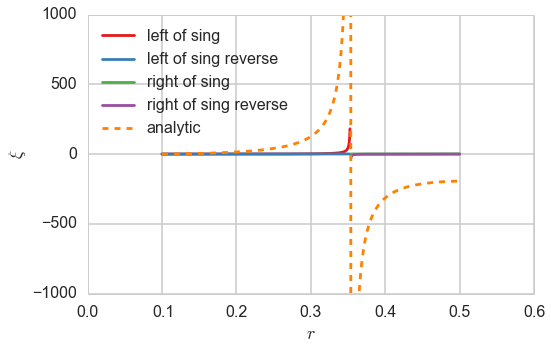

In [87]:
fig = plt.figure(figsize=(8,5))
plt.plot(rs_1_left, xi_1_left)
plt.plot(rs_1_right, xi_1_right)
plt.plot(rs_2_left, xi_2_left)
plt.plot(rs_2_right, xi_2_right)
plt.plot(params['r'], xi_constant_pressure(**xi_analytic_params), linestyle='--')
plt.legend(['left of sing','left of sing reverse','right of sing','right of sing reverse','analytic'], loc='best')
plt.ylabel(r'$\xi$')
plt.xlabel(r'$r$')
plt.ylim((-1000,1000))

## Close to the singularity

(-5, 5)

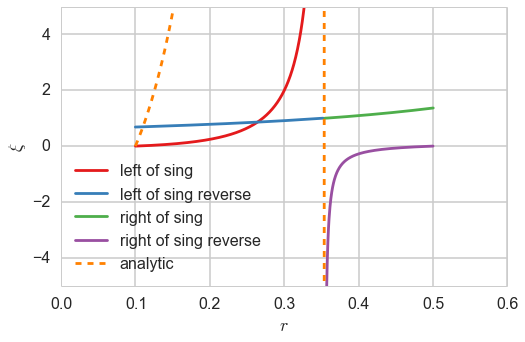

In [88]:
fig = plt.figure(figsize=(8,5))
plt.plot(rs_1_left, xi_1_left)
plt.plot(rs_1_right, xi_1_right)
plt.plot(rs_2_left, xi_2_left)
plt.plot(rs_2_right, xi_2_right)
plt.plot(params['r'], xi_constant_pressure(**xi_analytic_params), linestyle='--')
plt.legend(['left of sing','left of sing reverse','right of sing','right of sing reverse','analytic'], loc='best')
plt.ylabel(r'$\xi$')
plt.xlabel(r'$r$')
plt.ylim((-5, 5))

None of the integrations match the analytic curves but that is because the boundary conditions are not the same.
The integration left of the singularity and the analytic curve should just be off by a factor.

In [89]:
factor1 = xi_constant_pressure(**xi_analytic_params)[100]/xi_1_left[100]

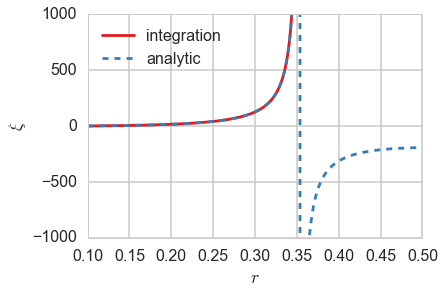

In [90]:
plt.plot(rs_1_left, xi_1_left*factor1)
plt.plot(params['r'], xi_constant_pressure(**xi_analytic_params), linestyle='--')
plt.ylim((-1000,1000))
plt.ylabel(r'$\xi$')
plt.xlabel(r'$r$')
plt.legend(['integration', 'analytic'], loc='best')

Now, let's look at the 4th curve from the right edge to the singularity. We have to adjust it's boundary condition so that it matches the analytic solution and adjust by a factor.

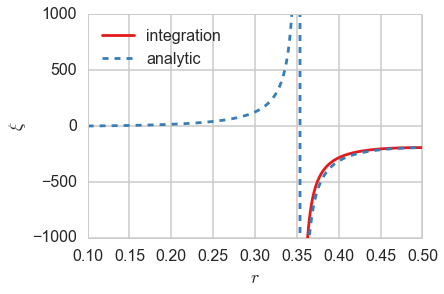

In [91]:
start = xi_constant_pressure(**xi_analytic_params)[-1]
start_diff = np.diff(xi_constant_pressure(**xi_analytic_params))[-1]
adjusted_solution_2_right = new.newcomb_int(params['r_0i'], -dr, zero_pos + sing_offset, params, init.init_xi_given, f.newcomb_f_16, 
                                             g.newcomb_g_18, mu_0, reverse=True, xi_init=(start, start_diff))

adjusted_crossing_2_right, adjusted_xi_2_right, adjusted_xi_der_2_right, adjusted_rs_2_right = adjusted_solution_2_right

plt.plot(rs_2_right, adjusted_xi_2_right)
plt.plot(params['r'], xi_constant_pressure(**xi_analytic_params), linestyle='--')
plt.ylabel(r'$\xi$')
plt.xlabel(r'$r$')
plt.legend(['integration', 'analytic'], loc='best')
plt.ylim((-1000,1000))
plt.show()

Even though the boundary condition matches. The curve is still off by 10%

In [92]:
print (xi_constant_pressure(**xi_analytic_params)[np.abs(params['r'] - 0.4).argmin()] / 
       adjusted_xi_2_right[np.abs(rs_2_right - 0.4).argmin()])

1.10423794026


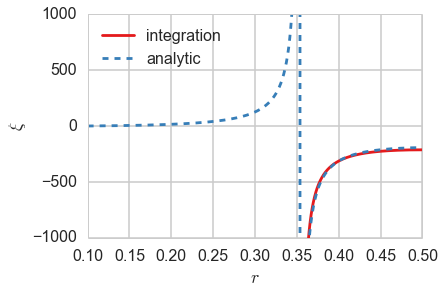

In [93]:
factor2 = (xi_constant_pressure(**xi_analytic_params)[np.abs(params['r'] - 0.4).argmin()] / 
           adjusted_xi_2_right[np.abs(rs_2_right - 0.4).argmin()])

plt.plot(rs_2_right, factor2*adjusted_xi_2_right)
plt.plot(params['r'], xi_constant_pressure(**xi_analytic_params), linestyle='--')
plt.ylabel(r'$\xi$')
plt.xlabel(r'$r$')
plt.legend(['integration', 'analytic'], loc='best')
plt.ylim((-1000,1000))
plt.show()

In [94]:
print (xi_constant_pressure(**xi_analytic_params)[-1] / 
       (factor2*adjusted_xi_2_right[0]))

0.905601921055


Adjusting the matched boundary curve by a factor doesen't help since this also shifts the boundary.

The integrations starting with the forbenius condition do not match at all since their values are finite close to the singularity.

(-5, 5)

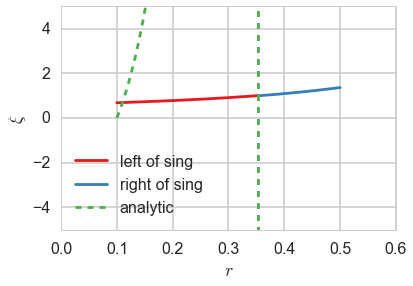

In [95]:
plt.plot(rs_1_right, xi_1_right)
plt.plot(rs_2_left, xi_2_left)
plt.plot(params['r'], xi_constant_pressure(**xi_analytic_params), linestyle='--')
plt.legend(['left of sing','right of sing','analytic'], loc='best')
plt.ylabel(r'$\xi$')
plt.xlabel(r'$r$')
plt.ylim((-5,5))